In [11]:
import numpy as np
import librosa.display, os
import matplotlib.pyplot as plt
%matplotlib inline

def create_spectrogram(audio_file, image_file):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)

    y, sr = librosa.load(audio_file)
    ms = librosa.feature.melspectrogram(y=y, sr=sr)
    log_ms = librosa.power_to_db(ms, ref=np.max)
    librosa.display.specshow(log_ms, sr=sr)

    fig.savefig(image_file)
    plt.close(fig)

def create_pngs_from_wavs(input_path, output_path):
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    dir = os.listdir(input_path)

    for i, file in enumerate(dir):
        input_file = os.path.join(input_path, file)
        output_file = os.path.join(output_path, file.replace('.wav', '.png'))
        create_spectrogram(input_file, output_file)

In [12]:
create_pngs_from_wavs('Sounds/background', 'Spectrograms/background')
create_pngs_from_wavs('Sounds/chainsaw', 'Spectrograms/chainsaw')
create_pngs_from_wavs('Sounds/engine', 'Spectrograms/engine')
create_pngs_from_wavs('Sounds/storm', 'Spectrograms/storm')

In [13]:
from tensorflow.keras.preprocessing import image

def load_images_from_path(path, label):
    images, labels = [], []

    for file in os.listdir(path):
        images.append(image.img_to_array(image.load_img(os.path.join(path, file),
                      target_size=(224, 224, 3))))
        labels.append((label))

    return images, labels

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20),
                             subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

x, y = [], []

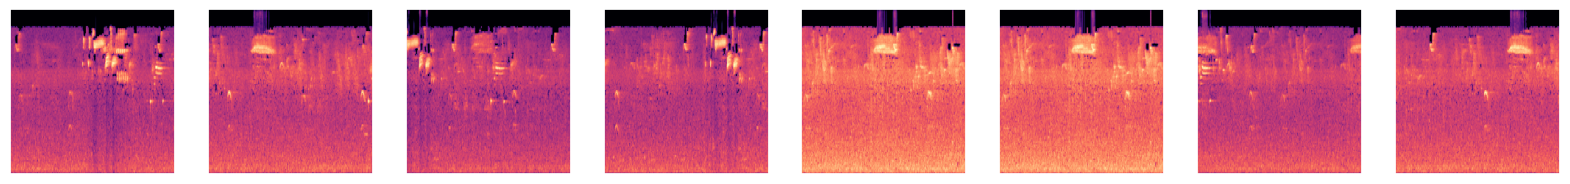

In [14]:
images, labels = load_images_from_path('Spectrograms/background', 0)
show_images(images)

x += images
y += labels

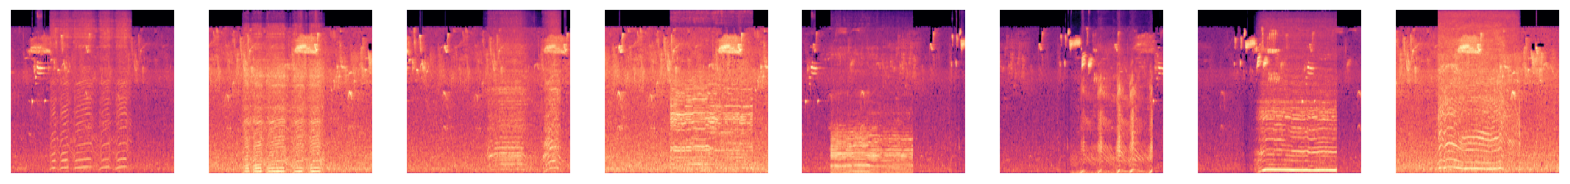

In [15]:
images, labels = load_images_from_path('Spectrograms/chainsaw', 1)
show_images(images)

x += images
y += labels

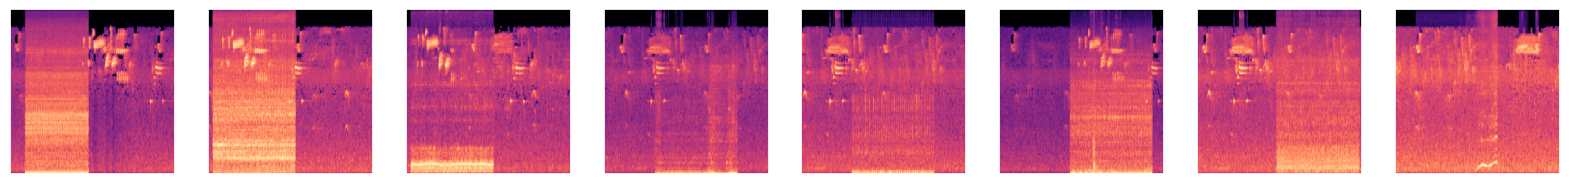

In [16]:
images, labels = load_images_from_path('Spectrograms/engine', 2)
show_images(images)

x += images
y += labels

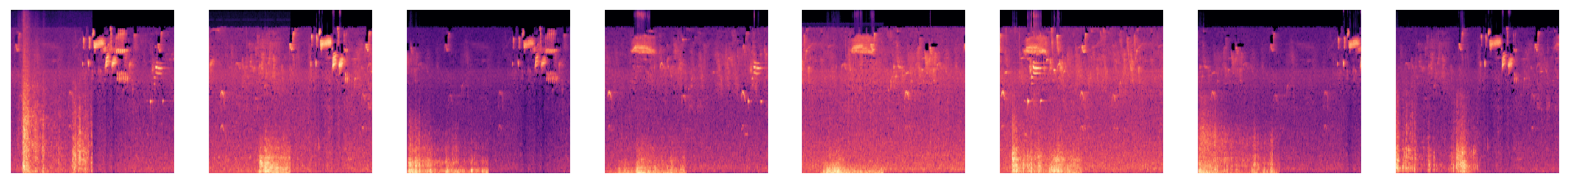

In [17]:
images, labels = load_images_from_path('Spectrograms/storm', 3)
show_images(images)

x += images
y += labels

In [18]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications.mobilenet import preprocess_input

x = preprocess_input(np.array(x))
y = np.array(y)

x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y,
                                                    test_size=0.3,
                                                    random_state=0)

In [19]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(224, 224, 3))

train_features = base_model.predict(x_train)
test_features = base_model.predict(x_test)

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 161ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential()
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(4, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [21]:
hist = model.fit(train_features, y_train,
                 validation_data=(test_features, y_test),
                 batch_size=10, epochs=10)

Epoch 1/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - accuracy: 0.4239 - loss: 48.2174 - val_accuracy: 0.8667 - val_loss: 2.5844
Epoch 2/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8731 - loss: 3.3090 - val_accuracy: 0.8000 - val_loss: 2.4713
Epoch 3/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9190 - loss: 0.9636 - val_accuracy: 0.8417 - val_loss: 3.9503
Epoch 4/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9325 - loss: 1.5921 - val_accuracy: 0.8667 - val_loss: 2.8971
Epoch 5/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9723 - loss: 0.4547 - val_accuracy: 0.9000 - val_loss: 2.6687
Epoch 6/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.9710 - loss: 0.4396 - val_accuracy: 0.9250 - val_loss: 1.7251
Epoch 7/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9890 - loss: 0.0803 - val_accuracy: 0.9167 - val_loss: 2.9719
Epoch 8/10
28/28 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 1.0000 - loss: 5.1850e-09 - val_accuracy: 0.925

[]

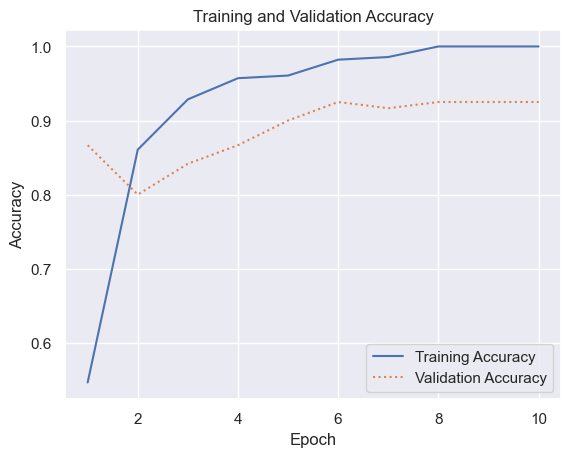

In [22]:
import seaborn as sns
sns.set()

acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, '-', label='Training Accuracy')
plt.plot(epochs, val_acc, ':', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.plot()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


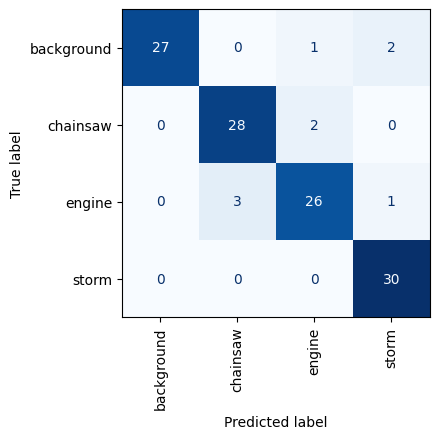

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay as cmd

sns.reset_orig()
fig, ax = plt.subplots(figsize=(4, 4))
ax.grid(False)

y_pred = model.predict(test_features)
class_labels = ['background', 'chainsaw', 'engine', 'storm']

cmd.from_predictions(y_test, y_pred.argmax(axis=1),
                     display_labels=class_labels, colorbar=False,
                     cmap='Blues', xticks_rotation='vertical', ax=ax)

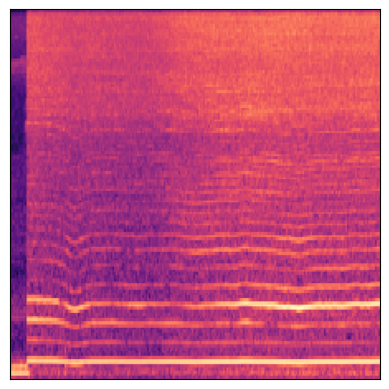

In [24]:
create_spectrogram('Sounds/samples/sample1.wav', 'Spectrograms/sample1.png')

x = image.load_img('Spectrograms/sample1.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [25]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
background: 0.0
chainsaw: 1.0
engine: 5.144215888984661e-26
storm: 0.0


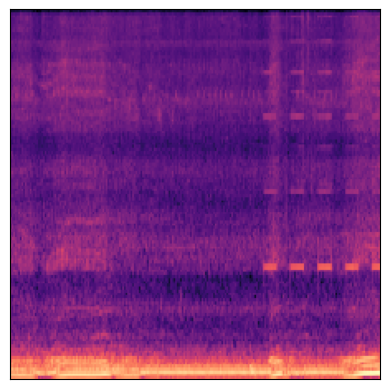

In [26]:
create_spectrogram('Sounds/samples/sample2.wav', 'Spectrograms/sample2.png')

x = image.load_img('Spectrograms/sample2.png', target_size=(224, 224))
plt.xticks([])
plt.yticks([])
plt.imshow(x)

In [27]:
x = image.img_to_array(x)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

y = base_model.predict(x)
predictions = model.predict(y)

for i, label in enumerate(class_labels):
    print(f'{label}: {predictions[0][i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
background: 0.0
chainsaw: 6.979132740525529e-05
engine: 0.9999302625656128
storm: 1.4686522035275307e-30
